<a href="https://colab.research.google.com/github/vichacker1234/Proyectos_IA/blob/main/Proyecto_PLN_Deteccion_suicidios_manu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo de clasificación


In [1]:
#Importar la librería tensorflow
import tensorflow as tf
print(tf.version.VERSION)

2.8.2


In [2]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


In [3]:
# Instalar requerimientos para utilizar el repositorio de tensorflow models
!pip install -Uqr models/official/requirements.txt
# Reiniciar el entorno de ejecución y volver a correr hasta acá

In [4]:
!pip install transformers 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 7.4 MB/s 
     |████████████████████████████████| 6.6 MB 40.7 MB/s 
     |████████████████████████████████| 101 kB 11.5 MB/s 


In [5]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
import transformers
from transformers import BertModel, BertTokenizer
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization
import seaborn as sns # Para realización de gráficos
import matplotlib.pyplot as plt # Para realización de gráficos
import numpy as np
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.models import Model, load_model #Creación y cargue del modelo
from transformers import pipeline

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
df = pd.read_csv('/content/gdrive/MyDrive/NLP/Proyecto_de_NLP_manu/Proyecto_NLP_Suicide_Detection_manu/Proyecto_NLP_Suicide_Detection/Suicide_Detection.csv',low_memory=False)
df.shape

(232074, 3)

In [8]:
#Imprimir los últimos 12 registros
df.tail(12)

,Unnamed: 0,text,class
232062,348092,paralyzing anxiety &amp; depression are pushin...,suicide
232063,348094,i have a cute ribbon tied around my neck and m...,non-suicide
232064,348096,How ba-a-ad can i be? I’m just doin’ what come...,non-suicide
232065,348097,I know no one here cares but anyways I was fig...,non-suicide
232066,348098,My mom tried to kill herself today. I feel los...,suicide
232067,348100,I’m a fucking scummy person and I can’t change...,suicide
232068,348101,I did something today I went sledding with my ...,non-suicide
232069,348103,If you don't like rock then your not going to ...,non-suicide
232070,348106,You how you can tell i have so many friends an...,non-suicide
232071,348107,pee probably tastes like salty tea😏💦‼️ can som...,non-suicide


In [9]:
#Función para quitar espacios y convertir en mayúsculas 
def limpieza(columna):
  x=columna.strip()
  y=x.upper()
  return y

In [10]:
#A la columna class se le quitan los espacios y se ponen las categorías en mayúsculas
df['class']=df['class'].apply(limpieza)
df['target'] = np.where(df['class']=='SUICIDE', 1, 0)
df=df[['text','class','target']]
df

,text,class,target
0,Ex Wife Threatening SuicideRecently I left my ...,SUICIDE,1
1,Am I weird I don't get affected by compliments...,NON-SUICIDE,0
2,Finally 2020 is almost over... So I can never ...,NON-SUICIDE,0
3,i need helpjust help me im crying so hard,SUICIDE,1
4,"I’m so lostHello, my name is Adam (16) and I’v...",SUICIDE,1
...,...,...,...
232069,If you don't like rock then your not going to ...,NON-SUICIDE,0
232070,You how you can tell i have so many friends an...,NON-SUICIDE,0
232071,pee probably tastes like salty tea😏💦‼️ can som...,NON-SUICIDE,0
232072,The usual stuff you find hereI'm not posting t...,SUICIDE,1


In [11]:
#Definir tipo de dato de las columnas
df = df.astype({'text': 'str','class': 'str','target': 'int64'})

In [12]:
#Verificar el tipo de las variables 
type(df['text'][1])

str

(232074, 3)

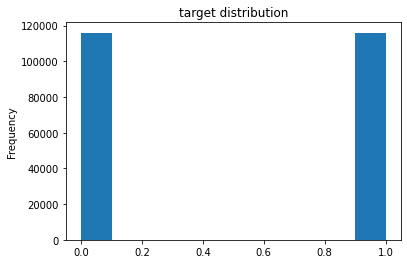

In [13]:
#Revisar la cantidad de noticias verdaderes (1) y falsas (0)
df.target.plot(kind='hist', title='target distribution')
df.shape

In [14]:
train_df, remaining = train_test_split(df, random_state=42, train_size=0.9, stratify=df.target.values)
valid_df, remaining2 = train_test_split(remaining, random_state=42, train_size=0.5, stratify=remaining.target.values)
test_df, _  = train_test_split(remaining2, random_state=42, train_size=0.9, stratify=remaining2.target.values)

train_df.shape, valid_df.shape, test_df.shape

((208866, 3), (11604, 3), (10443, 3))

In [15]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df['text'].values, train_df['target'].values))
  valid_data = tf.data.Dataset.from_tensor_slices((valid_df['text'].values, valid_df['target'].values))
  test_data =  tf.data.Dataset.from_tensor_slices((test_df['text'].values, test_df['target'].values)) 
  for text, label in train_data.take(5):
    print(text)
    print(label)  
    

tf.Tensor(b'Most of the "gifted" kids now have at least one mental illness. Telling a kid that they\'re gifted is basically like "wow you\'re only 11 and you already lost half your serotonin", change my mind That being said, what is your diagnosis bro?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b'Leading someone on is worse than rejecting them Even ghosting someone is better then leading them on, so to any of u mfs leading on multiple people either ghost them or tell them ur not interested for me pls', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b"I Am A MistakeI'll never have friends. I'll never have a gf. I'll never be employed by anyone. I'll never make anyone proud. I'll never succeed at anything. I'll never be anything other then a fat grotesque slob nobody wants to be seen dead with. I'll never have amazing experiences. I'll never travel to amazing places. \nI'm sure, for most people, it gets better. They find people in their

In [16]:
"""
Cada registro del conjunto de datos se compone, del texto y de su etiqueta
- El procesamiento de datos, consiste en transformar el texto a:
input_word_ids, input_mask, segment_ids que son los elementos de entrada del modelo BERT. 
- La tokenización de los textos se hace mendiante el tokenizador del modelo BERT.
"""
 # Etiquetas de las categorías
 # 1 - Noticia verdadera
 # 0 - Noticia false
label_list = [0,1]

 # Definición del tamaño del token
max_seq_length = 128
#Definición del tamaño del lote
train_batch_size = 32

# Carga del modelo preentrenado y el tokenizador del modelo 
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2', trainable=True)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [17]:
tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?')

['hi', '##,', 'how', 'are', 'you', 'doing', '##?']

In [18]:
tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?'))

[7632, 29623, 2129, 2024, 2017, 2725, 29632]

In [19]:
# La siguientes funciones convierte el texto en features de entrada con su respectiva etiqueta

def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid=None,
                                             text_a = text.numpy(),
                                             text_b = None,
                                             label = label.numpy())
  feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer)
  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

In [20]:
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text,label], Tout=[tf.int32, tf.int32, tf.int32, tf.int32])
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])
  x = {'input_words_ids' : input_ids,
       'input_mask': input_mask,
       'input_type_id': segment_ids
       }  
  return (x, label_id)

In [21]:
with tf.device('/cpu:0'):
  # Data de entrenamiento
  train_data = (train_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .shuffle(1000)
  .batch(32, drop_remainder=True)        
  .prefetch(tf.data.experimental.AUTOTUNE))

  # Data de validación
  valid_data = (valid_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .batch(32, drop_remainder=True)        
  .prefetch(tf.data.experimental.AUTOTUNE))

  #Data de prueba
  test_data = (test_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .batch(32, drop_remainder=True)        
  .prefetch(tf.data.experimental.AUTOTUNE))

In [22]:
# Especificaciones de la data de entrenamiento
train_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_id': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_words_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [23]:
#Especificaciones de la data de validación
valid_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_id': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_words_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [24]:
#Especificaciones de la data de test
test_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_id': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_words_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [25]:
# Construyendo la capa personalizada del modelo
def create_model():
  input_words_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_words_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
  input_type_id = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_type_id")
  pooled_output, sequence_output = bert_layer([input_words_ids, input_mask, input_type_id])
  drop = tf.keras.layers.Dropout(0.4)(pooled_output)
  output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(drop)
  model = tf.keras.Model(
           inputs = {
               'input_words_ids': input_words_ids,
               'input_mask': input_mask,
               'input_type_id': input_type_id          
           },
           outputs = output )
  return model

In [26]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_words_ids (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 input_type_id (InputLayer)     [(None, 128)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_words_ids[0][0]',        
                                 (None, 128, 768)]                'input_mask[0][0]',         

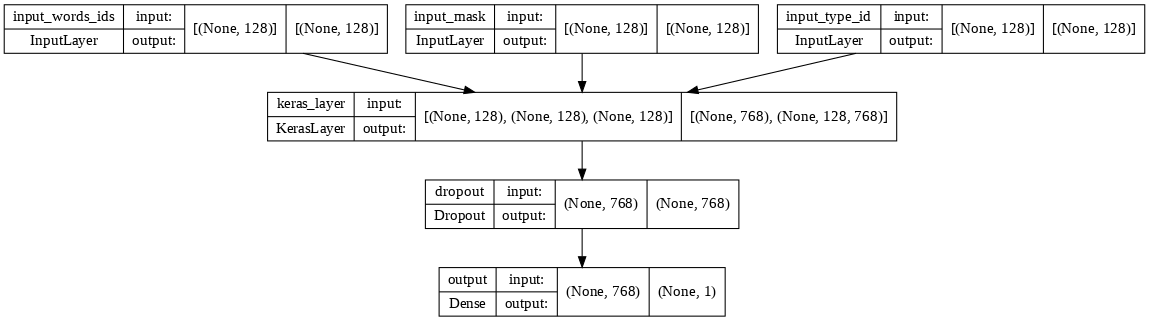

In [27]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76)

In [28]:
# Usar la parada temprana para parar el entrenamiento si la pérdida en validación no baja después de un cierto número de epochs 
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# Guardamos el modelo con menor error de validación
checkpointer = ModelCheckpoint(filepath="/content/gdrive/MyDrive/Proyecto NLP/Bert-weights_Clasification.hdf5", verbose=1, save_best_only=True)

#13. Cargar el modelo entrenado y evaluar la calidad del modelo


In [29]:
model = tf.keras.models.load_model(('/content/gdrive/MyDrive/NLP/Proyecto_de_NLP_manu/Proyecto_NLP_Suicide_Detection_manu/Proyecto_NLP_Suicide_Detection/Bert-weights_Clasification.hdf5'), custom_objects={'KerasLayer':hub.KerasLayer})

In [30]:
#Hacemos la predicción
test_predict = model.predict(test_data)


In [31]:
test_predict

array([[0.9999831 ],
       [0.999211  ],
       [0.9999875 ],
       ...,
       [0.9999746 ],
       [0.03605556],
       [0.00125417]], dtype=float32)

In [32]:
# Dado que usamos la función de activación sigmoide al final, nuestro resultado contiene valores continuos de 0 a 1.
# La red se usa  para clasificar si el twwet tiene tendencias suicidas o no

predict = []

##Menor a 0.5 es porque es cero, es decir no hay tendencias suicidas
##mayor a 0.5 es porque es uno, es decir hay tendencias suicidas
for i in test_predict:
  if i < 0.5: 
    predict.append(0)
  else:
    predict.append(1)

predict = np.asarray(predict)

In [33]:
len(predict)

10432

In [34]:
# 
original = np.asarray(test_df.target)[:10432]
len(original)

10432

In [35]:
# Buscamos la accuracy del modelo
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(original, predict)
accuracy

0.970954754601227

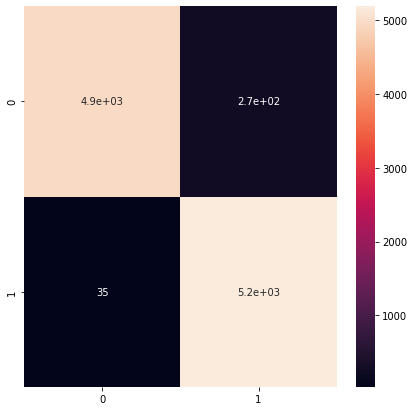

In [36]:
# Representamos la matriz de confusión
import seaborn as sns # Para realización de gráficos
import matplotlib.pyplot as plt # Para realización de gráficos
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)
plt.show()

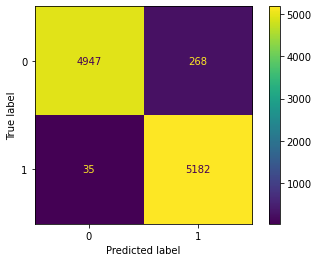

In [37]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
ConfusionMatrixDisplay.from_predictions(original, predict)
plt.show()

In [38]:
##Filtrar los de la categoría suicide
df2=df['class'] == 'SUICIDE'
df3=df[df2]
df3=df3.reset_index()
df3=df3[['text','class','target']]
#Seleccionar la columna de texto 
df4=df3.text

#Convertir a lista
tweets_en_lista=df4.to_numpy().tolist()

In [ ]:
##Obtener la probabilidad de todos los tweets
test_data = tf.data.Dataset.from_tensor_slices((tweets_en_lista, [1]*len(tweets_en_lista)))
test_data = test_d
ata.map(to_feature_map).batch(1)

preds = model.predict(test_data)
preds 

type(preds)



